# MSDS 699 -- ML Lab -- Week 5 -- Metrics

This notebook demonstrates how to compute AUROC and AUPRC for two models and compare them.

In [ ]:
# @title Imports

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc

from sklearn.model_selection import train_test_split

from scipy.stats import random_correlation

import numpy as np
import pandas as pd

from plotnine import *

In [ ]:
# @title Functions for generating random features and labels.

def generate_data(n: int = 1000,
                  p: int = 10,
                  beta_range: list[float] = [0, 2],
                  sigma: float = 1.0,
                  corr: np.array = None) -> tuple:
  """Generate random features and labels using a logistic model.

  Arguments:
    n (int): The number of samples.
    p (int): The number of parameters.
    beta_range (list[float]): The lower and upper bounds of the coefficients.
    corr (np.array): A correlation structure to impose on the features.

  Returns:
    A tuple (X, y, beta) containing the feature matrix, labels and true betas.
  """

  # Generate random features.
  p = int(p)
  if corr is None:
    covar = np.diag(np.full(p, sigma))
  else:
    assert(corr.shape[0] == p)
    assert(corr.shape[1] == p)
    covar = corr * sigma
  X = np.random.multivariate_normal(np.zeros(p), covar, n)
  # Generate random coefficients.
  assert(len(beta_range) == 2)
  assert(beta_range[0] <= beta_range[1])
  beta = np.random.uniform(size = p, low = beta_range[0], high = beta_range[1])
  # Convert features and parameters to probabilities.
  eta = np.dot(X, beta)
  mu = np.exp(eta) / (1 + np.exp(eta))

  # Generate binary labels
  y = np.random.binomial(n = 1, p = mu)

  return X, y, beta

def generate_correlation(p: int = 10) -> np.array:
  """Generate a correlation matrix based on a random vector of eigenvalues.

  Arguments:
    p (int): Dimensionality of the correlation matrix.

  Returns:
    A correlation matrix with shape (p, p).
  """

  p = int(p)
  assert(p > 1)
  # Generate some uniform random variables.
  u = np.random.uniform(size=p)
  # Scale the random numbers so that they sum to p.
  eigen = u * p / np.sum(u)
  # Return correlation.
  return random_correlation.rvs(eigen)

In [ ]:
# @title Input parameters
n = 1000
p = 10

In [ ]:
# @title Correlated features.
np.random.seed(8657309)
corr = generate_correlation(p = p)
Xc, yc, betac = generate_data(n = n, p = p, corr = corr)

In [ ]:
# @title Uncorrelated features
np.random.seed(8657309)
X, y, beta = generate_data(n = n, p = p)

In [ ]:
y.mean()

0.498

## Split into train, test.

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(X, y, test_size = 0.2, random_state = 8675309)
)

## Use Logistic Regression to construct probabilities.

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]

In [ ]:
np.array([lr.coef_[0], beta]).T

array([[0.99763497, 1.00698762],
       [1.95456478, 1.88495058],
       [0.17964014, 0.13299779],
       [0.88568694, 0.95159256],
       [1.70847798, 1.69048063],
       [0.62231321, 0.38871902],
       [1.00140053, 1.06136116],
       [1.72301048, 1.78568908],
       [0.41281799, 0.45519492],
       [0.61897813, 0.63711516]])

Construct ROC and AUROC for Logistic Regression.

In [ ]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred)
lr_auroc = auc(lr_fpr, lr_tpr)

Construct PRC and AUPRC for Logistic Regression.

In [ ]:
lr_p, lr_r, _ = precision_recall_curve(y_test, lr_pred)
lr_auprc = auc(lr_r, lr_p)

## Use Random Forest to construct probabilities.

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict_proba(X_test)[:, 1]

Construct ROC and AUROC for Random Forest.

In [ ]:
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred)
rf_auroc = auc(rf_fpr, rf_tpr)

Construct PRC and AUPRC for Random Forest.

In [ ]:
rf_p, rf_r, _ = precision_recall_curve(y_test, rf_pred)
rf_auprc = auc(rf_r, rf_p)

## Plot curves

In [ ]:
# @title Plotting code, including custom theme.
def my_theme(font_size: int = 16,
             figure_size: list = [8, 6],
             legend_position: str = 'top') -> theme:
  th = theme_bw()
  th += theme(
    figure_size = figure_size,
    panel_grid = element_blank(),
    axis_title = element_text(size = font_size, family = 'sans'),
    axis_text = element_text(size = font_size, family = 'sans'),
    strip_text = element_text(size = font_size, family = 'sans'),
    strip_background = element_rect(fill = 'white'),
    legend_direction = 'vertical',
    legend_position = legend_position,
    legend_title = element_blank(),
    legend_text = element_text(size = font_size),
    legend_background = element_rect(fill = 'white')
  )
  return th

def plot_models(x1: np.array,
                y1: np.array,
                auc1: float,
                x2: np.array,
                y2: np.array,
                auc2: float,
                label: str,
                color_values: list = ['steelblue', 'darkgoldenrod'],
                font_size: int = 14,
                figure_size = [10, 6],
                legend_position: list = [0.3, 0.15]) -> ggplot:
  label1 = 'Logistic Regression (%s = %0.3f)' % (label, auc1)
  label2 = 'Random Forest (%s = %0.3f)' % (label, auc2)
  compare = pd.concat([
      pd.DataFrame({'x': x1, 'y': y1, 'label': label1}),
      pd.DataFrame({'x': x2, 'y': y2, 'label': label2})
  ])
  if label == 'AUROC':
    xlab = 'False Positive Rate'
    ylab = 'True Positive Rate'
  else:
    xlab = 'Recall'
    ylab = 'Precision'
  gg = ggplot(compare, aes(x = 'x', y = 'y'))
  gg += geom_line(aes(color = 'label'))
  if label == 'AUROC':
    gg += geom_abline(intercept = 0, slope = 1, color = 'darkgray', alpha = 0.5)
  gg += my_theme(
      font_size = font_size,
      figure_size = figure_size,
      legend_position = legend_position)
  gg += scale_color_manual(values = color_values)
  gg += guides(color = guide_legend(override_aes = {'size': 5}))
  gg += labs(x = xlab, y = ylab)
  return gg

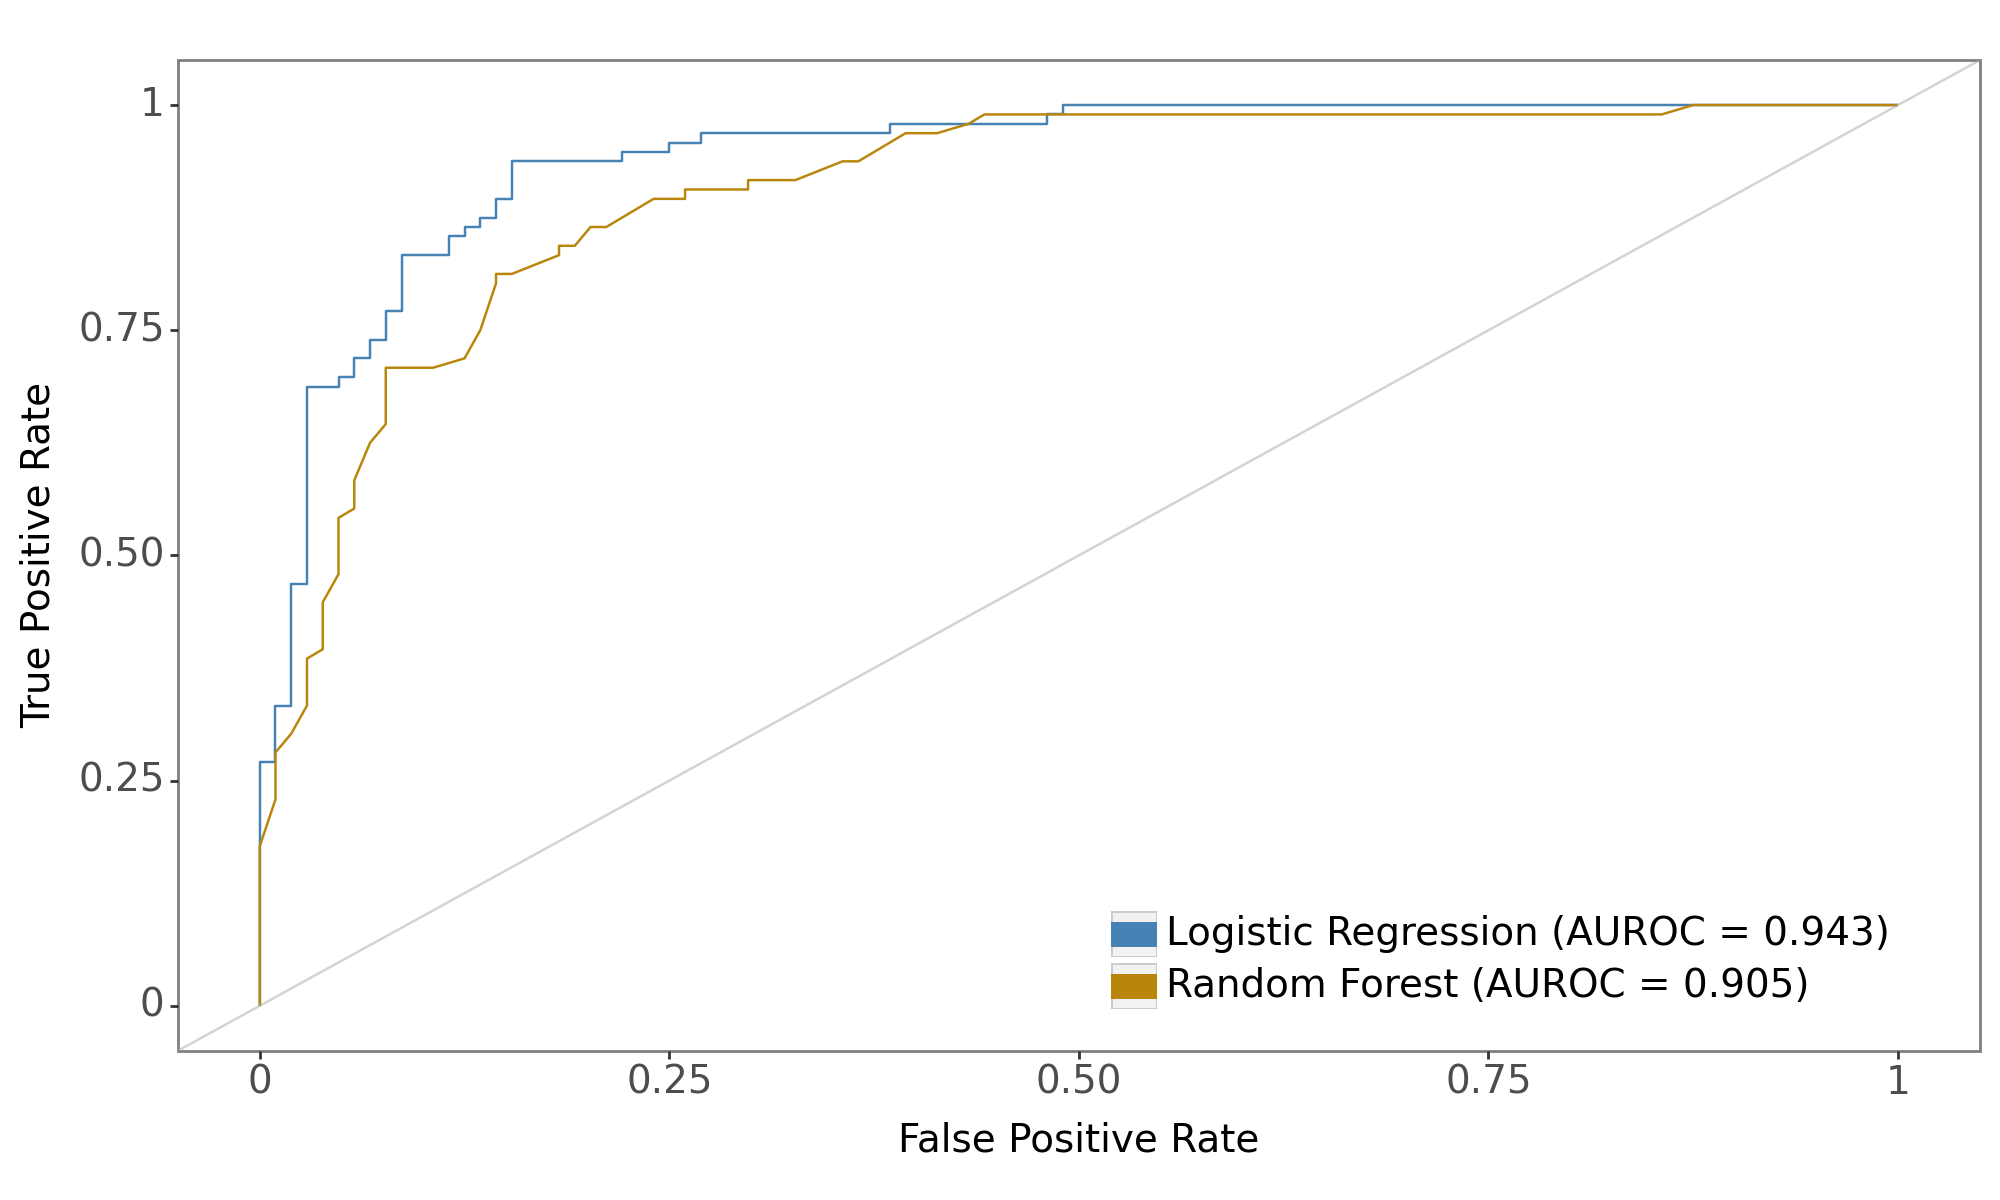

<Figure Size: (1000 x 600)>

In [ ]:
plot_models(lr_fpr, lr_tpr, lr_auroc, rf_fpr, rf_tpr, rf_auroc,
            label = 'AUROC', legend_position = [0.75, 0.2])

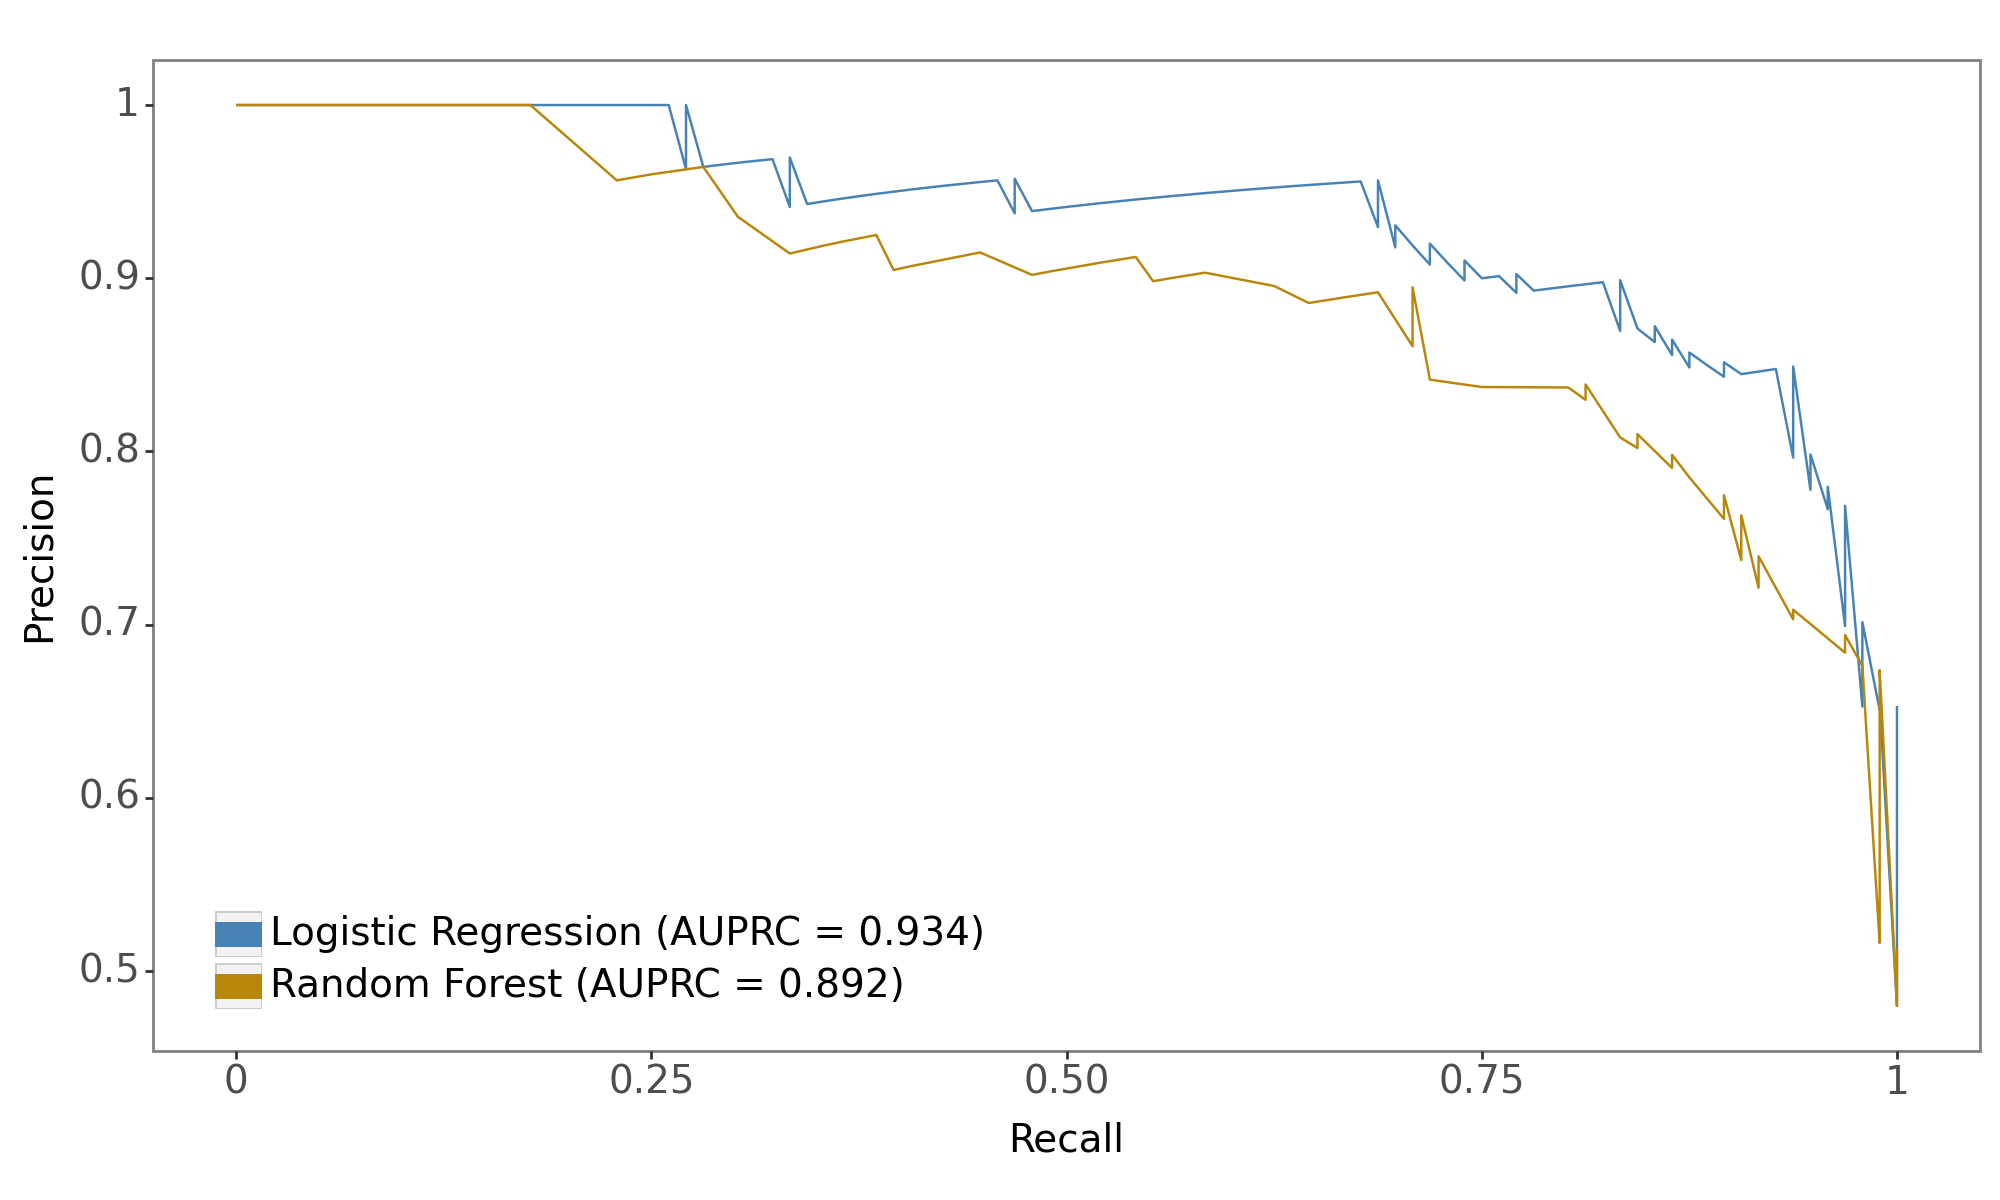

<Figure Size: (1000 x 600)>

In [ ]:
plot_models(lr_r, lr_p, lr_auprc, rf_r, rf_p, rf_auprc,
            label = 'AUPRC', legend_position = [0.3, 0.2])